#### This notebook uses the dataset from Kaggle : https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Going to check the number of samples in each directory

In [2]:
train_dir='/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir='/kaggle/input/chest-xray-pneumonia/chest_xray/test'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

def sample_count(direct,dirname):
    sub_dir = os.listdir(direct)
    for direc in sub_dir:
            classpath=os.path.join(direct, direc)
            filelist = os.listdir(classpath)
            print(f"Number of samples in {dirname} directory for {direc} is {len(filelist)}")  


sample_count(train_dir,"training")
sample_count(test_dir,"testing")
sample_count(val_dir,"validation")
    

Number of samples in training directory for PNEUMONIA is 3875
Number of samples in training directory for NORMAL is 1341
Number of samples in testing directory for PNEUMONIA is 390
Number of samples in testing directory for NORMAL is 234
Number of samples in validation directory for PNEUMONIA is 8
Number of samples in validation directory for NORMAL is 8


#### Next I will check the average height and width of each image to get the average dimensions of the image and also visualize one of the images using the cv2 library methods

average height=  1384  average width=  1660 aspect ratio=  0.8337418472860421
(1128, 1336, 3)


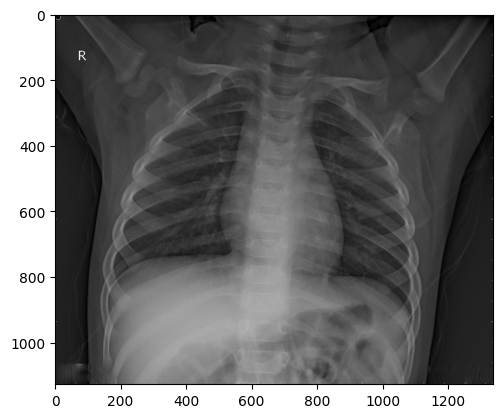

In [3]:
import random
import cv2

train_normal_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL'
filelist = os.listdir(train_normal_path)
random_samples = random.sample(filelist, 100)
ht=0
wt=0
for x in random_samples:
    img_path = os.path.join(train_normal_path,x )
    #print(img_path)
    img=plt.imread(img_path)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

test_img = cv2.imread(os.path.join(train_normal_path,filelist[0] ))
plt.imshow(test_img)
print(test_img.shape)

#### Next step is load all the images using the keras keras.utils.image_dataset_from_directory API. The folder structure follows the convention recommended by keras and hence the labels can be inferred based on the directory structure

In [4]:
batch_size = 32
img_width, img_height = 256, 256

train_ds = keras.utils.image_dataset_from_directory(
    directory = train_dir,
    labels='inferred',
    label_mode = 'binary',
    batch_size=batch_size,
    image_size=(img_width, img_height)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = val_dir,
    labels='inferred',
    label_mode = 'binary',
    batch_size=batch_size,
    image_size=(img_width, img_height)
)

test_ds = keras.utils.image_dataset_from_directory(
    directory = test_dir,
    labels='inferred',
    label_mode = 'binary',
    batch_size=batch_size,
    image_size=(img_width, img_height)
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


#### Note that the label mode used is binary as there are only two classes in the dataset, this would mean that the loss function to be used during compilation of model will be binary_crossentropy. Other options available for label mode are INT (similar to sparse_categorical_crossentropy where labels are encoded as Integers ) and CATEGORICAL (similar to categorical_crossentropy where labels are OHE)

#### Next step is to normalize the images before it can be used for training

In [5]:
train_ds.class_names

['NORMAL', 'PNEUMONIA']

In [6]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_normal_ds = train_ds.map(process)
validation_normal_ds = validation_ds.map(process)
test_normal_ds = test_ds.map(process)


# Display the first batch of normalized images and labels
for images, labels in train_normal_ds.take(1):
    print("Normalized Images Shape:", images.shape)
    print("Labels:", labels)

Normalized Images Shape: (32, 256, 256, 3)
Labels: tf.Tensor(
[[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]], shape=(32, 1), dtype=float32)


#### Going to build the neural network which uses pre-trained VGG16 model 

In [7]:
from keras.applications.vgg16 import VGG16
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)
conv_base.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [8]:
pretrained_model = Sequential()

pretrained_model.add(conv_base)
pretrained_model.add(Flatten())
pretrained_model.add(Dense(256,activation='relu'))
pretrained_model.add(Dropout(0.2))
pretrained_model.add(Dense(1,activation='sigmoid'))

In [9]:
pretrained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 23103809 (88.13 MB)
Trainable params: 8389121 (32.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [11]:
pretrained_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = pretrained_model.fit(train_normal_ds,epochs=5,validation_data=validation_normal_ds)

Epoch 1/5
163/163 [==============================] - 45s 189ms/step - loss: 0.2998 - accuracy: 0.9291 - val_loss: 0.2823 - val_accuracy: 0.8750
Epoch 2/5
163/163 [==============================] - 26s 153ms/step - loss: 0.0508 - accuracy: 0.9812 - val_loss: 0.1921 - val_accuracy: 0.8750
Epoch 3/5
163/163 [==============================] - 27s 157ms/step - loss: 0.0388 - accuracy: 0.9866 - val_loss: 0.0584 - val_accuracy: 1.0000
Epoch 4/5
163/163 [==============================] - 27s 159ms/step - loss: 0.0257 - accuracy: 0.9919 - val_loss: 0.0608 - val_accuracy: 1.0000
Epoch 5/5
163/163 [==============================] - 27s 162ms/step - loss: 0.0224 - accuracy: 0.9941 - val_loss: 0.2383 - val_accuracy: 0.8750


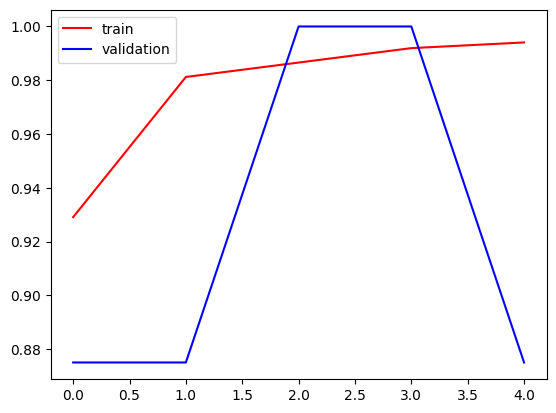

In [12]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

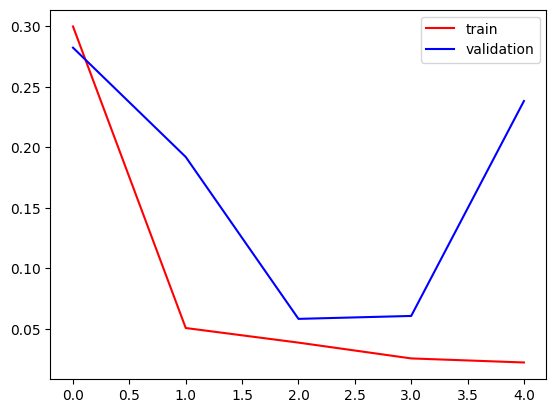

In [14]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

#### Validation dataset has only 8 samples of each class, so above drop in validation accuracy is negligible. Going to test the predictions of a few images from the test dataset next

In [15]:
from keras.models import load_model

pretrained_model.save('Pneumonia_Detection.keras')  

#### Picking a random sample from NORMAL dataset to make prediction

(2085, 1970, 3)


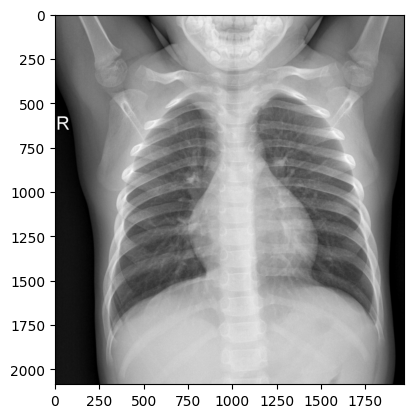

In [18]:
test_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL'

filelist = os.listdir(test_path)
test_img2 = cv2.imread(os.path.join(test_path,filelist[5] ))
plt.imshow(test_img2)
print(test_img2.shape)

#### the shape of train_normal_ds used for training is (32, 256, 256, 3), where 32 is the batch size. For testing just 1 image, we will reshape the image as (1,256,256,3) 

In [19]:
test_img2 = cv2.resize(test_img2,(256,256))
test_input = test_img2.reshape((1,256,256,3))
pretrained_model.predict(test_input)

1/1 [==============================] - 0s 20ms/step


array([[0.]], dtype=float32)

#### based on the classnames printed above we can see that class 0 is NORMAL and class 1 is PNEUMONIA. The model has correctly predicted the above image as a NORMAL Check X-Ray

#### Picking a random sample from Penumonia dataset to make prediction

(1312, 1632, 3)
1/1 [==============================] - 0s 20ms/step


array([[1.]], dtype=float32)

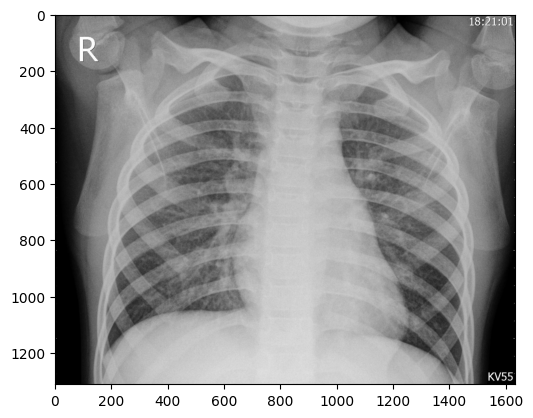

In [21]:
test_path_p = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA'

filelist = os.listdir(test_path_p)
test_img3 = cv2.imread(os.path.join(test_path_p,filelist[5] ))
plt.imshow(test_img3)
print(test_img3.shape)
test_img3 = cv2.resize(test_img3,(256,256))
test_input = test_img3.reshape((1,256,256,3))
pretrained_model.predict(test_input)

#### The model has correctly predicted the above image to be a chest X-ray showing signs of Pneumonia